In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('RSCCASN.csv', parse_dates=True, index_col='DATE')

In [8]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [10]:
df.describe()

,RSCCASN
count,334.000000
mean,16325.095808
std,5369.839014
min,6938.000000
25%,12298.500000
50%,15878.500000
75%,19772.500000
max,34706.000000


In [11]:
df.columns = ['Sales']

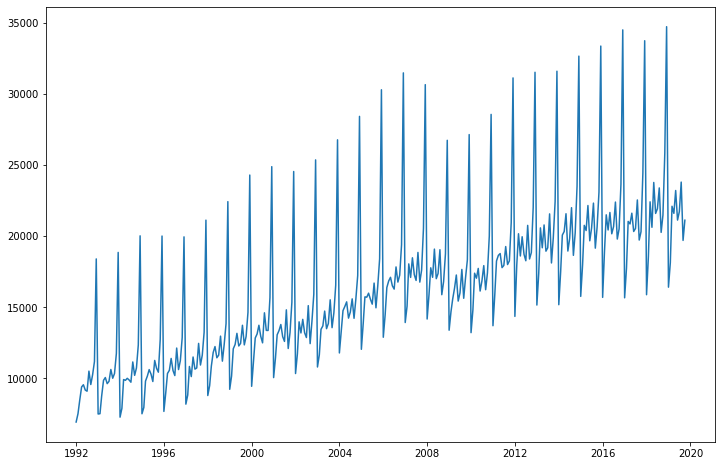

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(df)

In [17]:
len(df)

334

In [18]:
test_size = 18

In [20]:
test_ind = len(df) - test_size

In [21]:
test_ind

316

In [25]:
train = df.iloc[:test_ind] # 0 to 316
test = df.iloc[test_ind:] # 316 to 334

In [26]:
len(train)

316

In [27]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [30]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [33]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [34]:
len(test)

18

In [35]:
length = 12 # a whole year
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [86]:
X, y = generator[303]

In [87]:
X # one year - 12 months X is given and we need to predict 13th month data which is y

array([[[0.50515539],
        [0.53252977],
        [0.48591345],
        [0.49364653],
        [0.56629393],
        [0.46405751],
        [0.48536886],
        [0.63534708],
        [0.97233517],
        [0.32468051],
        [0.42285071],
        [0.5615016 ]]])

In [88]:
y # y denotes predicted 13th month value based on prior 12 months (X)

array([[0.49658728]])

In [90]:
scaled_train

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266],
       [0.02047633],
       [0.02127505],
       [0.06636654],
       [0.10633895],
       [0.11345484],
       [0.09791606],
       [0.10368864],
       [0.13396747],
       [0.11163956],
       [0.12372931],
       [0.17506535],
       [0.43250799],
       [0.0124165 ],
       [0.03499855],
       [0.10829945],
       [0.10641156],
       [0.11149434],
       [0.10728289],
       [0.10154662],
       [0.1531731 ],
       [0.11904589],
       [0.13767064],
       [0.19663085],
       [0.47480395],
       [0.02105722],
       [0.03714058],
       [0.10445106],
       [0.11726692],
       [0.13367703],
       [0.12209556],
       [0.10332559],
       [0.1570578 ],
       [0.13694453],
       [0.12710572],
       [0.21104415],
       [0.474

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [138]:
n_features = 1

In [165]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [166]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [167]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [168]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [169]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
322/322 [==============================] - 7s 23ms/step - loss: 0.0284 - val_loss: 0.0036
Epoch 2/20
322/322 [==============================] - 5s 16ms/step - loss: 0.0195 - val_loss: 0.0042
Epoch 3/20
322/322 [==============================] - 6s 18ms/step - loss: 0.0162 - val_loss: 0.0048


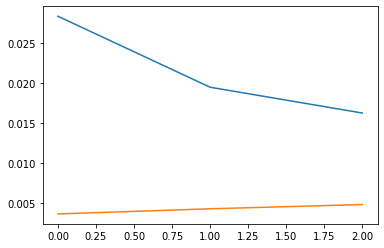

In [170]:
loss = pd.DataFrame(model.history.history)
plt.plot(loss)

In [145]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    # predict one step ahead
    current_prediction = model.predict(current_batch)[0]
    
    # save all predictions to test_predictions list
    test_predictions.append(current_prediction)
    
    # update batch with last prediction and drop previous values
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)

In [146]:
real_predictions = scaler.inverse_transform(test_predictions)

In [147]:
test['Predictions'] = real_predictions

C:\Users\agamm\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


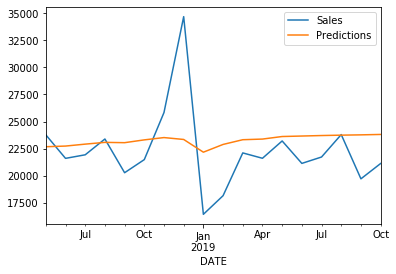

In [148]:
test.plot()

In [149]:
# Forecast future


In [150]:
full_scaler = MinMaxScaler()

In [151]:
scaled_all_data = full_scaler.fit_transform(df)

In [152]:
length = 12
generator = TimeseriesGenerator(scaled_all_data, scaled_all_data, length=length, batch_size=1)

In [153]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [154]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [155]:
model.fit_generator(generator, epochs=8)

Epoch 1/8
322/322 [==============================] - 7s 22ms/step - loss: 0.0282: 0s - los
Epoch 2/8
322/322 [==============================] - 5s 15ms/step - loss: 0.0184
Epoch 3/8
322/322 [==============================] - 6s 18ms/step - loss: 0.0114
Epoch 4/8
322/322 [==============================] - 7s 21ms/step - loss: 0.0050
Epoch 5/8
322/322 [==============================] - 5s 17ms/step - loss: 0.0027
Epoch 6/8
322/322 [==============================] - 6s 18ms/step - loss: 0.0023: 0s - loss: 0.002
Epoch 7/8
322/322 [==============================] - 6s 18ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 6s 17ms/step - loss: 0.0016


In [156]:
forecast = []

periods = 12

first_eval_batch = scaled_all_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    # predict one step ahead
    current_prediction = model.predict(current_batch)[0]
    
    # save all predictions to test_predictions list
    forecast.append(current_prediction)
    
    # update batch with last prediction and drop previous values
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)

In [157]:
real_forecast = scaler.inverse_transform(forecast)

In [158]:
real_forecast

array([[24408.61067677],
       [31383.20609188],
       [17087.66914821],
       [18424.17212749],
       [21374.1700983 ],
       [20970.6541338 ],
       [22170.50766563],
       [20595.71529651],
       [21051.65481186],
       [22606.49416828],
       [19651.30662465],
       [20706.08688807]])

In [159]:
forecast_index = pd.date_range(start='2019-11-01', periods=12, freq="MS")

In [160]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [161]:
forecast_df = pd.DataFrame(forecast, forecast_index, columns=['Forecast'])

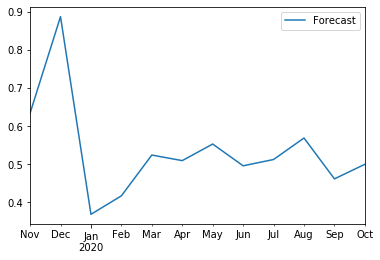

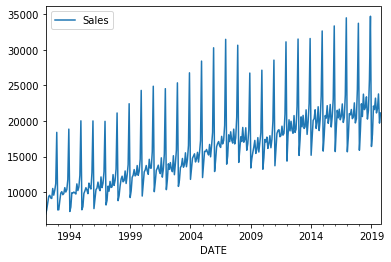

In [162]:
forecast_df.plot()
df.plot()

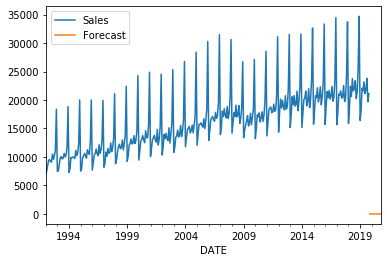

In [164]:
ax = df.plot()
forecast_df.plot(ax=ax)
# plt.xlim('2018-01-01', '2020-01-10')